In [1]:
from pyspark.sql import SparkSession

try:
    spark = SparkSession \
        .builder \
        .appName("BigData_Project2_workers") \
        .config("spark.dynamicAllocation.enabled", "false") \
        .config("spark.executor.instances", "7") \
        .getOrCreate()
except:
    Pass

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/30 17:58:40 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
23/05/30 17:58:41 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
23/05/30 17:58:41 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
23/05/30 17:58:41 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [2]:
print("version: " + spark.version)
sc = spark.sparkContext
num_workers = int(sc.getConf().get("spark.executor.instances", "0"))
print(f"executors: {num_workers}")

version: 3.1.3
executors: 7


In [3]:
df = spark.read.format("csv").option("header","true").load("gs://myproject-bdpp2023-bucket1/data.csv").cache()

In [1]:
#all imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')
import time

from pyspark.sql.types import StringType
from pyspark.sql.functions import mean
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, when, mean, sum
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import StringIndexer

from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator


In [5]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [6]:
df.show(2)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|         No|    

In [7]:
from pyspark.sql.functions import mean as _mean

# Cast "TotalCharges" to double, keep null if casting fails
df = df.withColumn("TotalCharges_double", col("TotalCharges").cast("double"))

# Calculate the mean of "TotalCharges" excluding nulls
mean_total_charges = df.filter(df["TotalCharges_double"].isNotNull()).agg(_mean("TotalCharges_double")).first()[0]

# Fill nulls in "TotalCharges_double" with mean
df = df.na.fill({"TotalCharges_double": mean_total_charges})

# Drop the original "TotalCharges" column
df = df.drop("TotalCharges")

In [8]:
# get the list of string columns
string_cols = [c.name for c in df.schema.fields if c.dataType == StringType()]

# loop over the string columns and apply StringIndexer
for col in string_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col + "_indexed")
    df = indexer.fit(df).transform(df)
    
# drop the original string columns
df = df.drop(*string_cols)

# show the resulting DataFrame
df.show(10)

+-------------------+------------------+--------------+---------------------+---------------+------------------+--------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+----------------------+-------------+
|TotalCharges_double|customerID_indexed|gender_indexed|SeniorCitizen_indexed|Partner_indexed|Dependents_indexed|tenure_indexed|PhoneService_indexed|MultipleLines_indexed|InternetService_indexed|OnlineSecurity_indexed|OnlineBackup_indexed|DeviceProtection_indexed|TechSupport_indexed|StreamingTV_indexed|StreamingMovies_indexed|Contract_indexed|PaperlessBilling_indexed|PaymentMethod_indexed|MonthlyCharges_indexed|Churn_indexed|
+-------------------+------------------+--------------+---------------------+---------------+------------------+--------------+---------------

In [9]:
'''
Label Encoder Transformation
gender  :  [0 1]  =  ['Female' 'Male']
Partner  :  [1 0]  =  ['Yes' 'No']
Dependents  :  [0 1]  =  ['No' 'Yes']
PhoneService  :  [0 1]  =  ['No' 'Yes']
MultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']
InternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']
OnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
OnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']
DeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
TechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
StreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']
Contract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling  :  [1 0]  =  ['Yes' 'No']
PaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn  :  [0 1]  =  ['No' 'Yes']
'''

"\nLabel Encoder Transformation\ngender  :  [0 1]  =  ['Female' 'Male']\nPartner  :  [1 0]  =  ['Yes' 'No']\nDependents  :  [0 1]  =  ['No' 'Yes']\nPhoneService  :  [0 1]  =  ['No' 'Yes']\nMultipleLines  :  [1 0 2]  =  ['No phone service' 'No' 'Yes']\nInternetService  :  [0 1 2]  =  ['DSL' 'Fiber optic' 'No']\nOnlineSecurity  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']\nOnlineBackup  :  [2 0 1]  =  ['Yes' 'No' 'No internet service']\nDeviceProtection  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']\nTechSupport  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']\nStreamingTV  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']\nStreamingMovies  :  [0 2 1]  =  ['No' 'Yes' 'No internet service']\nContract  :  [0 1 2]  =  ['Month-to-month' 'One year' 'Two year']\nPaperlessBilling  :  [1 0]  =  ['Yes' 'No']\nPaymentMethod  :  [2 3 0 1]  =  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'\n 'Credit card (automatic)']\nChurn  :  [0 1]  =  ['No' 'Yes']\n"

In [10]:
df1 = (df.drop("customerID_indexed"))
df1.head()

Row(TotalCharges_double=29.85, gender_indexed=1.0, SeniorCitizen_indexed=0.0, Partner_indexed=1.0, Dependents_indexed=0.0, tenure_indexed=0.0, PhoneService_indexed=1.0, MultipleLines_indexed=2.0, InternetService_indexed=1.0, OnlineSecurity_indexed=0.0, OnlineBackup_indexed=1.0, DeviceProtection_indexed=0.0, TechSupport_indexed=0.0, StreamingTV_indexed=0.0, StreamingMovies_indexed=0.0, Contract_indexed=0.0, PaperlessBilling_indexed=0.0, PaymentMethod_indexed=0.0, MonthlyCharges_indexed=997.0, Churn_indexed=0.0)

In [11]:
#Balancing the Data 
train_data, test_data = df1.randomSplit([0.8, 0.2], seed=42)
# Split the data into positive and negative cases
positive_cases = df1.filter(df['Churn_indexed'] == 1)
negative_cases = df1.filter(df['Churn_indexed'] == 0)

# Calculate the ratio of positive to negative cases
ratio = positive_cases.count() / negative_cases.count()

# Sample the negative cases
sampled_negative_cases = negative_cases.sampleBy('Churn_indexed', fractions={0: ratio})

# Combine the positive and negative cases
balanced_df = positive_cases.union(sampled_negative_cases)
train_data, test_data = balanced_df.randomSplit([0.8, 0.2], seed=42)

In [12]:
dt = DecisionTreeClassifier(labelCol='Churn_indexed', featuresCol='features')
rf = RandomForestClassifier(labelCol='Churn_indexed', featuresCol='features')
gbt = GBTClassifier(labelCol='Churn_indexed', featuresCol='features')
lr = LogisticRegression(labelCol='Churn_indexed', featuresCol='features')

In [13]:
evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed')

assembler = VectorAssembler(
    inputCols=[
        "TotalCharges_double", "gender_indexed",
        "SeniorCitizen_indexed", "Partner_indexed", "Dependents_indexed",
        "tenure_indexed", "MultipleLines_indexed",
        "InternetService_indexed", "OnlineSecurity_indexed", "OnlineBackup_indexed",
        "DeviceProtection_indexed", "TechSupport_indexed", "StreamingTV_indexed",
        "StreamingMovies_indexed", "Contract_indexed", "PaperlessBilling_indexed",
        "PaymentMethod_indexed", "MonthlyCharges_indexed"],
    outputCol="features")


In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
import time
import pandas as pd

# Define models
models = {
    "DecisionTree": DecisionTreeClassifier(labelCol='Churn_indexed', featuresCol='features', maxBins = 3512),
    "RandomForest": RandomForestClassifier(labelCol='Churn_indexed', featuresCol='features', maxBins = 3512),
    "GBTClassifier": GBTClassifier(labelCol='Churn_indexed', featuresCol='features', maxBins = 3512),
    "LogisticRegression": LogisticRegression(labelCol='Churn_indexed', featuresCol='features')
}

# Initialize evaluator
evaluator = BinaryClassificationEvaluator(labelCol='Churn_indexed', rawPredictionCol="rawPrediction")

results = []

for name, model in models.items():
    pipeline = Pipeline(stages=[assembler, model])
    
    # Train
    start_time_train = time.time()
    model_fitted = pipeline.fit(train_data)
    end_time_train = time.time()

    # Evaluate
    predictions = model_fitted.transform(test_data)
    start_time_eva = time.time()
    auc = evaluator.evaluate(predictions)
    end_time_eva = time.time()
    # Append the results
    results.append({
        "Workers": num_workers,
        "model": name,
        "auc": auc,
        "train_time": end_time_train - start_time_train,
        "evaluate_time": end_time_eva - start_time_eva,
    })

# Read the existing results, if the file exists
try:
    df = pd.read_csv("results_mo.csv")
except FileNotFoundError:
    df = pd.DataFrame()

# Append new results
df = df.append(results, ignore_index=True)

# Save the updated results
df.to_csv("results_mo.csv", index=False)

23/05/30 17:59:54 WARN org.apache.spark.ml.tree.impl.DecisionTreeMetadata: DecisionTree reducing maxBins from 3512 to 3072 (= number of training instances)
23/05/30 18:00:06 WARN org.apache.spark.ml.tree.impl.DecisionTreeMetadata: DecisionTree reducing maxBins from 3512 to 3072 (= number of training instances)
23/05/30 18:00:17 WARN org.apache.spark.ml.tree.impl.DecisionTreeMetadata: DecisionTree reducing maxBins from 3512 to 3072 (= number of training instances)
23/05/30 18:00:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
23/05/30 18:00:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1018.4 KiB
23/05/30 18:00:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1019.8 KiB
23/05/30 18:00:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1038.1 KiB
23/05/30 18:00:40 WARN org.apache.spark.scheduler.DAGScheduler: Broa

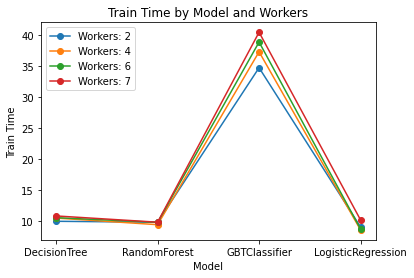

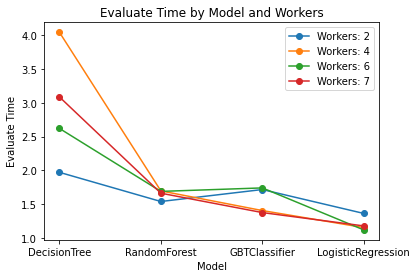

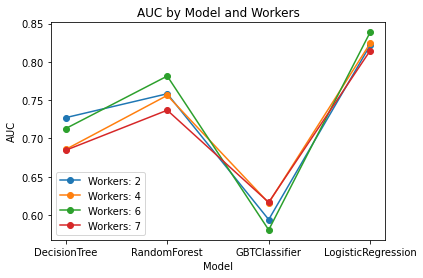

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('gs://myproject-bdpp2023-bucket1/results_mo.csv')

# Group the data by the 'Workers' column
grouped_data = data.groupby('Workers')

# Initialize a figure and axes for train_time
fig_train, ax_train = plt.subplots()

# Iterate over each group and plot the data for train_time
for name, group in grouped_data:
    ax_train.plot(group['model'], group['train_time'], marker='o', label=f'Workers: {name}')

# Set labels and title for train_time plot
ax_train.set_xlabel('Model')
ax_train.set_ylabel('Train Time')
ax_train.set_title('Train Time by Model and Workers')

# Add a legend for train_time plot
ax_train.legend()

# Initialize a figure and axes for evaluate_time
fig_evaluate, ax_evaluate = plt.subplots()

# Iterate over each group and plot the data for evaluate_time
for name, group in grouped_data:
    ax_evaluate.plot(group['model'], group['evaluate_time'], marker='o', label=f'Workers: {name}')

# Set labels and title for evaluate_time plot
ax_evaluate.set_xlabel('Model')
ax_evaluate.set_ylabel('Evaluate Time')
ax_evaluate.set_title('Evaluate Time by Model and Workers')

# Add a legend for evaluate_time plot
ax_evaluate.legend()

# Initialize a figure and axes for AUC
fig_auc, ax_auc = plt.subplots()

# Iterate over each group and plot the data for AUC
for name, group in grouped_data:
    ax_auc.plot(group['model'], group['auc'], marker='o', label=f'Workers: {name}')

# Set labels and title for AUC plot
ax_auc.set_xlabel('Model')
ax_auc.set_ylabel('AUC')
ax_auc.set_title('AUC by Model and Workers')

# Add a legend for AUC plot
ax_auc.legend()

# Display the plots
plt.show()


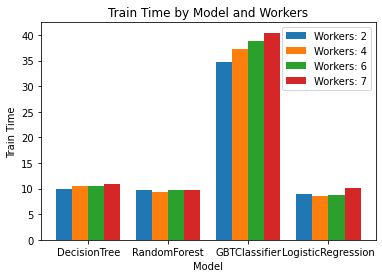

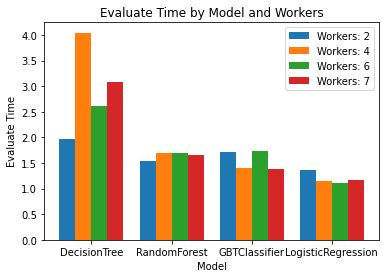

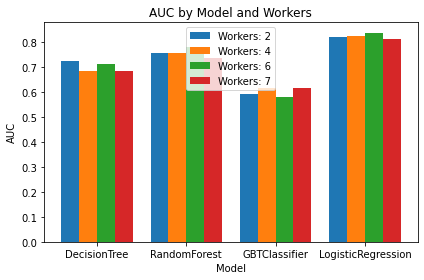

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file into a pandas DataFrame
data = pd.read_csv('gs://myproject-bdpp2023-bucket1/results_mo.csv')

# Group the data by the 'Workers' column
grouped_data = data.groupby('Workers')

# Get unique model names
models = data['model'].unique()

# Set the bar width
bar_width = 0.2

# Calculate the positions for the bars
positions = np.arange(len(models))

# Initialize a figure and axes for train_time
fig_train, ax_train = plt.subplots()

# Iterate over each group and plot the data for train_time as a bar plot
for i, (name, group) in enumerate(grouped_data):
    ax_train.bar(positions + i * bar_width, group['train_time'], bar_width, label=f'Workers: {name}')

# Set the x-axis labels and tick positions
ax_train.set_xticks(positions + bar_width * (len(grouped_data) - 1) / 2)
ax_train.set_xticklabels(models)

# Set labels and title for train_time plot
ax_train.set_xlabel('Model')
ax_train.set_ylabel('Train Time')
ax_train.set_title('Train Time by Model and Workers')

# Add a legend for train_time plot
ax_train.legend()

# Initialize a figure and axes for evaluate_time
fig_evaluate, ax_evaluate = plt.subplots()

# Iterate over each group and plot the data for evaluate_time as a bar plot
for i, (name, group) in enumerate(grouped_data):
    ax_evaluate.bar(positions + i * bar_width, group['evaluate_time'], bar_width, label=f'Workers: {name}')

# Set the x-axis labels and tick positions
ax_evaluate.set_xticks(positions + bar_width * (len(grouped_data) - 1) / 2)
ax_evaluate.set_xticklabels(models)

# Set labels and title for evaluate_time plot
ax_evaluate.set_xlabel('Model')
ax_evaluate.set_ylabel('Evaluate Time')
ax_evaluate.set_title('Evaluate Time by Model and Workers')

# Add a legend for evaluate_time plot
ax_evaluate.legend()

# Initialize a figure and axes for AUC
fig_auc, ax_auc = plt.subplots()

# Iterate over each group and plot the data for AUC as a bar plot
for i, (name, group) in enumerate(grouped_data):
    ax_auc.bar(positions + i * bar_width, group['auc'], bar_width, label=f'Workers: {name}')

# Set the x-axis labels and tick positions
ax_auc.set_xticks(positions + bar_width * (len(grouped_data) - 1) / 2)
ax_auc.set_xticklabels(models)

# Set labels and title for AUC plot
ax_auc.set_xlabel('Model')
ax_auc.set_ylabel('AUC')
ax_auc.set_title('AUC by Model and Workers')

# Add a legend for AUC plot
ax_auc.legend()

# Adjust the layout to prevent overlapping of x-axis labels
plt.tight_layout()

# Display the plots
plt.show()
